# Kaggle - Understanding the Amazon from Space

## Data loading

In [1]:
import os
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from sklearn.neighbors import KNeighborsClassifier
import cv2
from skimage import io
from tqdm import tqdm
from snorkel.labeling import labeling_function, LabelModel, PandasLFApplier, LFAnalysis, MajorityLabelVoter
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
#labels_df.head()

In [4]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
#print(label_list)
            
# Preprocess labels
label_map = {l: i for i, l in enumerate(label_list)}

In [5]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [6]:
def sample_images(tags, n=None, complement=False):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == (not complement)
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [7]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            #print('Found image {}'.format(path))
            return io.imread(path)
    # If this line reached, image not found
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

## Data inspection

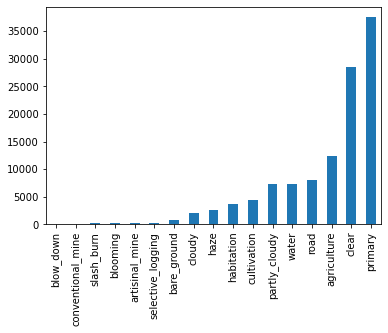

In [8]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

In [9]:
def cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

selected_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'water', 'road']
#cooccurence_matrix(selected_labels)

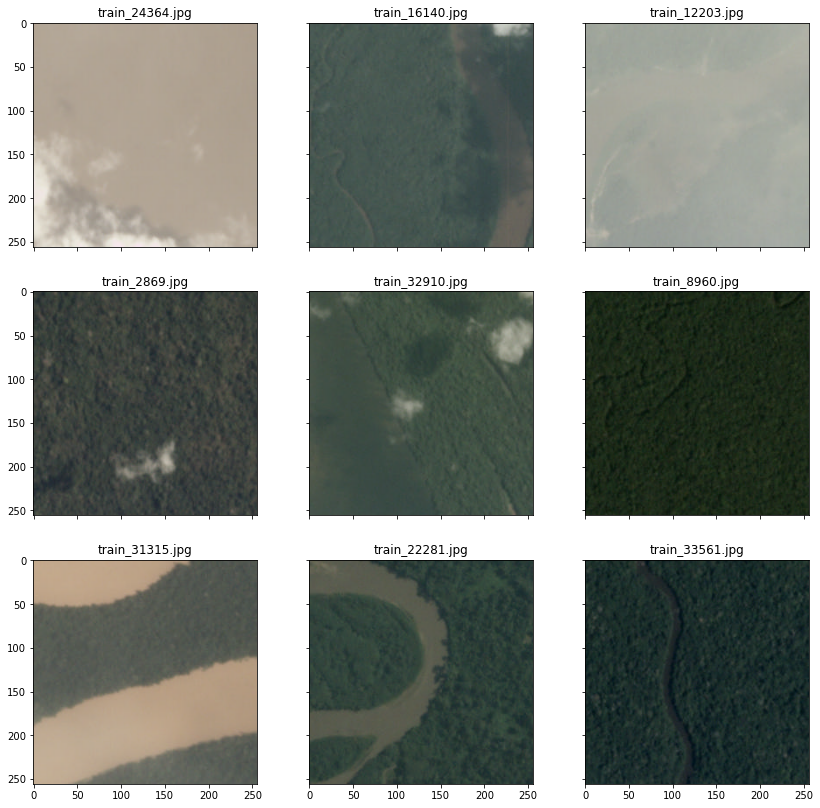

In [10]:
sampled_images = sample_images(['water'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]        
        
        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

## Labeling functions - helper functions and preprocessing



In [11]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def evaluate_LF(LF, df, tag, n=1000, full_dataset = True, print_evaluation=True):
    #print(namestr(LF, globals()))
    
    if full_dataset:
        n = df.shape[0]
    
    # Sample n images from the dataset
    sampled_images = df[:].sample(n)

    # Evaluate
    tp, fp, tn, fn = 0, 0, 0, 0
    abst = 0
    for index, row in sampled_images.iterrows():
        pred = LF(row)
        if pred == 1: 
            if row[tag] == 1:
                tp += 1
            else:
                fp += 1
        elif pred == 0:
            if row[tag] == 0:
                tn += 1
            else:
                fn += 1
        else:
            abst += 1  

    # Calculate the accuracy of LF
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp/(tp + fn)
    F1 = 2* (precision*recall)/(precision+recall)
    coverage = (n - abst) / n
    
    if print_evaluation:
        print('TP: ', tp)
        print('FP: ', fp)
        print('TN: ', tn)
        print('FN: ', fn)
        print('abstain: ', abst)
        print('accuracy: ', accuracy)
        print('precision: ', precision)
        print('recall: ', recall)
        print('F1: ', F1)
        print('coverage: ', coverage)
        
    return

In [12]:
# Splits of the original Kaggle dataset for training, validation and testing
SPLIT_TRAIN = 10000
SPLIT_VALIDATE = 12000

Load BigEarthNet remote sensing pre-trained model (Sentinel-2 data, 590k size)
https://arxiv.org/pdf/1911.06721.pdf

Model was subsequently trained on 12k (10k training, 2k validation) labeled jpg images from the Kaggle training dataset (see remote_sensing.py)

In [14]:
#import tensorflow as tf
#import tensorflow_hub as hub

batch_size = 128
heigth = 224
width = 224
no_channels = 3

# Create model and load model weights
#module = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1")
#model = tf.keras.Sequential([module,
#                             tf.keras.layers.Dense(17, activation="sigmoid")])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build(input_shape = (batch_size, heigth, width, no_channels))
#model.load_weights('../models/trained/bigearthnet-resnet_model_v05_weights.hdf5')
#model.summary()


Predict labels with the pre-trained model and set thresholds for abstaining

In [15]:
# Prepare array of images to predict classes with model
#x_train = []
y_train = []


for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
#    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
#    x_train.append(cv2.resize(img, (224, 224)))
    y_train.append(targets)    
    
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train, np.float16) / 255.

#x_train, x_valid, x_test = (x_train[:SPLIT_TRAIN], x_train[SPLIT_TRAIN:SPLIT_VALIDATE], x_train[SPLIT_VALIDATE:])
y_train, y_valid, y_test = (y_train[:SPLIT_TRAIN], y_train[SPLIT_TRAIN:SPLIT_VALIDATE], y_train[SPLIT_VALIDATE:])


100%|██████████| 40479/40479 [00:00<00:00, 160203.16it/s]


In [16]:
# Predict
#p_train = model.predict(x_train, batch_size=128)
#p_valid = model.predict(x_valid, batch_size=128)
#p_test = model.predict(x_test, batch_size=128)

# Directly load predicted features for the complete dataset (computed on cluster)
p_train = np.genfromtxt('../models/predictions/features_bigearth_v06_p_train.csv', delimiter=',')
p_valid = np.genfromtxt('../models/predictions/features_bigearth_v06_p_valid.csv', delimiter=',')
p_test = np.genfromtxt('../models/predictions/features_bigearth_v06_p_test.csv', delimiter=',')

#assert len(p_test)== len(y_test)

print(p_test[:3,:])
#print(y_test[:3,:])

[[4.88168597e-01 9.80332732e-01 6.12525344e-02 3.62358421e-01
  4.12835777e-02 9.16162133e-03 3.38178575e-02 1.78963244e-02
  2.44247913e-03 9.82058048e-03 1.28939927e-01 1.61060691e-03
  1.01838410e-02 1.17114186e-03 7.61008263e-03 2.70891190e-03
  3.03727388e-03]
 [2.47734785e-03 9.92867112e-01 7.00310111e-01 8.13476682e-01
  2.47898936e-01 5.92001379e-02 1.32741868e-01 1.49581850e-01
  5.58599830e-03 5.37276268e-04 1.41373038e-01 3.11499834e-03
  9.06886160e-02 2.08328366e-02 1.02986693e-02 4.39661741e-03
  4.10342216e-03]
 [8.55540037e-01 8.89050007e-01 1.54513180e-01 4.68403995e-02
  1.61963075e-01 1.69787705e-02 5.77568710e-02 2.91395783e-02
  1.95530057e-03 1.02427930e-01 5.63713312e-02 2.09730864e-03
  1.07714236e-02 1.01163983e-03 1.61665678e-03 1.01438165e-03
  1.25804543e-03]]


In [17]:
# Set thresholds for voting positive and abstaining

import scipy.stats

def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


resnet_thresholds = np.zeros((len(label_list),2))

# Calculate positive and abstain thresholds based on mean and std. deviation of predictions of train samples
for i in range(len(label_list)):
    arr = np.multiply(p_valid[:, i], y_valid[:, i])
    non_zero_arr = arr[np.where(arr!=0)]
    _, resnet_thresholds[i,0], _ = mean_confidence_interval(non_zero_arr)
    
    arr = np.multiply(p_valid[:, i], np.logical_not(y_valid[:, i]))
    non_zero_arr = arr[np.where(arr!=0)]
    _, _, resnet_thresholds[i,1] = np.minimum(mean_confidence_interval(non_zero_arr), resnet_thresholds[i,0])

print(resnet_thresholds[:,:])

[[ 4.34697135e-01  4.60413384e-02]
 [ 9.77005450e-01  5.27294026e-01]
 [ 6.45682334e-01  1.47399456e-01]
 [ 8.69168979e-01  2.65808712e-01]
 [ 5.42492332e-01  1.15322297e-01]
 [ 3.66905611e-01  5.96805918e-02]
 [ 5.89549578e-01  8.88502919e-02]
 [ 2.30557992e-01  7.09633402e-02]
 [ 2.47694539e-03  2.47694539e-03]
 [ 5.58929689e-01  1.20882850e-02]
 [ 5.91473136e-01  1.13720894e-01]
 [-1.19595617e-02 -1.19595617e-02]
 [ 8.03865766e-02  2.11557546e-02]
 [ 1.61002552e-01  5.49323834e-03]
 [ 1.96210605e-02  9.10638614e-03]
 [ 1.20344979e-02  7.95532241e-03]
 [ 4.81597143e-04  4.81597143e-04]]


Compute UMAP embedding for ResNet features to "draw" LFs in a plane as opposed to setting thresholds based on mean and std_dev

In [18]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=60,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)

#reducer.fit(np.concatenate((p_train,p_valid,p_test), axis = 0))
reducer.fit(p_test)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
     n_neighbors=60, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [19]:
embedding_UMAP = reducer.transform(p_test) 

In [20]:
# Manually set polygons within UMAP embedding to cluster/label data for following labels:
# 0 - haze
# 1 - primary
# 2 - agriculture
# 3 - clear
# 4 - water
# 5 - habitation
# 6 - road
# 9 - cloudy
# 10 - partly_cloudy

from shapely.geometry import Point, Polygon

resnet_coords = [[] for i in range(17)]
resnet_coords[0] = [(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)]
resnet_coords[1] = [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)]
resnet_coords[2] = [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)]
resnet_coords[3] = [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)]
resnet_coords[4] = [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)]
resnet_coords[5] = [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)]
resnet_coords[6] = [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)]
resnet_coords[9] = [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)]
resnet_coords[10] = [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)]

print(resnet_coords)

[[(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)], [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)], [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)], [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)], [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)], [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)], [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)], [], [], [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)], [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)], [], [], [], [], [], []]


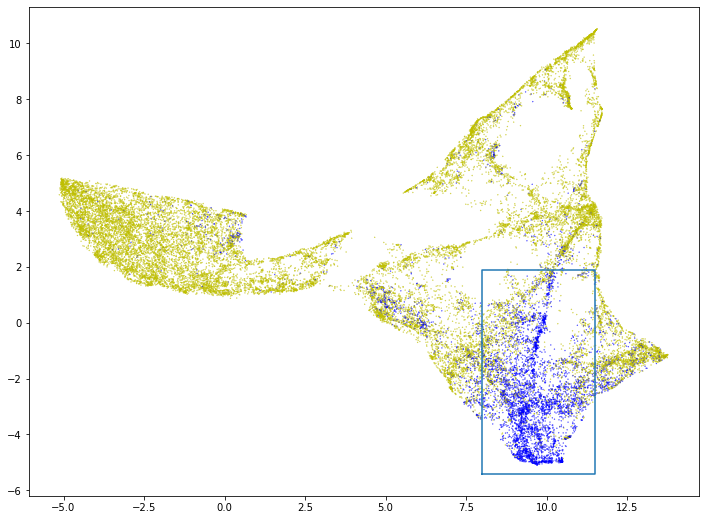

In [21]:
# Display manual clustering of the UMAP embedding

label_id = 6

coords = resnet_coords[label_id]
poly = Polygon(coords)

color = []
for i in range(len(y_test)):
#for i in range(600):
    if y_test[i,label_id] == 1:
        color.append('b') #
    else:
        color.append('y') #other

plt.figure(figsize=(12,9))
plt.scatter(embedding_UMAP[:, 0], embedding_UMAP[:, 1], c=color, s=0.1, cmap='Scatter')
#plt.scatter(embedding_UMAP[:600, 0], embedding_UMAP[:600, 1], c=color, s=0.1, cmap='Scatter')
plt.plot(*poly.exterior.xy)

Split df with labels for training, validation and testing datasets

In [22]:
labels_df_train = labels_df.iloc[:SPLIT_TRAIN]
labels_df_valid = labels_df.iloc[SPLIT_TRAIN:SPLIT_VALIDATE]
labels_df_test = labels_df.iloc[SPLIT_VALIDATE:]

## Labelling functions for selected classes

Classes considered: haze, primary, agriculture, clear, water, road, cloudy, partly_cloudy, habitation

In [23]:
# Define label mappings for Snorkle voting for convenience
NEGATIVE = 0
POSITIVE = 1
ABSTAIN = -1

In [24]:
# Define category mappings within labels_df for convenience
HAZE_MAP = 0
PRIMARY_MAP = 1
AGRICULTURE_MAP = 2
CLEAR_MAP = 3
WATER_MAP = 4
HABITATION_MAP = 5
ROAD_MAP = 6
CLOUDY_MAP = 9
PARTLY_CLOUDY_MAP = 10 

In [25]:
@labeling_function()
def habitation_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,0]:
        return POSITIVE
    elif p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [315]:
evaluate_LF(habitation_ResNet_1, labels_df_test, 'habitation', full_dataset = True)

TP:  1217
FP:  731
TN:  20482
FN:  238
abstain:  5811
accuracy:  0.9572525145579672
precision:  0.6247433264887063
recall:  0.836426116838488
F1:  0.715251248898031
coverage:  0.7959549141472664


In [27]:
@labeling_function()
def habitation_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HABITATION_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [316]:
evaluate_LF(habitation_ResNet_2, labels_df_test, 'habitation', full_dataset = True)

TP:  1061
FP:  665
TN:  25260
FN:  1493
abstain:  0
accuracy:  0.9242248674461884
precision:  0.6147161066048668
recall:  0.4154267815191856
F1:  0.49579439252336444
coverage:  1.0


In [29]:
@labeling_function()
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [317]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = True)

TP:  908
FP:  125
TN:  24681
FN:  7
abstain:  2758
accuracy:  0.9948680066871428
precision:  0.8789932236205228
recall:  0.9923497267759562
F1:  0.9322381930184804
coverage:  0.9031567119632009


In [31]:
@labeling_function()
def haze_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,HAZE_MAP] > resnet_thresholds[HAZE_MAP,0]:
        return POSITIVE
    elif p_test[i, HAZE_MAP] > resnet_thresholds[HAZE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [318]:
evaluate_LF(haze_ResNet_1, labels_df_test, 'haze', full_dataset = True)

TP:  1126
FP:  563
TN:  21909
FN:  108
abstain:  4773
accuracy:  0.9716949295536995
precision:  0.6666666666666666
recall:  0.9124797406807131
F1:  0.7704413274033527
coverage:  0.8324028231328348


In [33]:
@labeling_function()
def haze_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HAZE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [319]:
evaluate_LF(haze_ResNet_2, labels_df_test, 'haze', full_dataset = True)

TP:  1074
FP:  448
TN:  26124
FN:  833
abstain:  0
accuracy:  0.9550194880438218
precision:  0.7056504599211564
recall:  0.563188253801783
F1:  0.6264216972878391
coverage:  1.0


In [35]:
@labeling_function()
def primary_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,0]:
        return POSITIVE
    elif p_test[i, PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [320]:
evaluate_LF(primary_ResNet_1, labels_df_test, 'primary', full_dataset = True)

TP:  22389
FP:  93
TN:  1228
FN:  196
abstain:  4573
accuracy:  0.987910984690036
precision:  0.9958633573525487
recall:  0.9913216736772194
F1:  0.993587325537533
coverage:  0.8394255416271639


In [37]:
@labeling_function()
def primary_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[PRIMARY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [321]:
evaluate_LF(primary_ResNet_2, labels_df_test, 'primary', full_dataset = True)

TP:  26085
FP:  775
TN:  1295
FN:  324
abstain:  0
accuracy:  0.9614101618736612
precision:  0.9711466865227103
recall:  0.9877314551857321
F1:  0.9793688636918282
coverage:  1.0


In [39]:
@labeling_function()
def agriculture_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,0]:
        return POSITIVE
    elif p_test[i, AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [322]:
evaluate_LF(agriculture_ResNet_1, labels_df_test, 'agriculture', full_dataset = True)

TP:  5373
FP:  848
TN:  14599
FN:  544
abstain:  7115
accuracy:  0.9348436622355364
precision:  0.8636875100466163
recall:  0.9080615176609769
F1:  0.8853188334157192
coverage:  0.7501667895642403


In [41]:
@labeling_function()
def agriculture_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[AGRICULTURE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [323]:
evaluate_LF(agriculture_ResNet_2, labels_df_test, 'agriculture', full_dataset = True)

TP:  6681
FP:  1970
TN:  17855
FN:  1973
abstain:  0
accuracy:  0.8615471048843008
precision:  0.7722806611952375
recall:  0.7720129419921423
F1:  0.7721467783877491
coverage:  1.0


In [43]:
@labeling_function()
def clear_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,0]:
        return POSITIVE
    elif p_test[i, CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [324]:
evaluate_LF(clear_ResNet_1, labels_df_test, 'clear', full_dataset = True)

TP:  14816
FP:  454
TN:  5462
FN:  314
abstain:  7433
accuracy:  0.9635085051791314
precision:  0.9702685003274394
recall:  0.9792465300727032
F1:  0.9747368421052631
coverage:  0.739000667158257


In [45]:
@labeling_function()
def clear_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLEAR_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [325]:
evaluate_LF(clear_ResNet_2, labels_df_test, 'clear', full_dataset = True)

TP:  19439
FP:  2562
TN:  5899
FN:  579
abstain:  0
accuracy:  0.8897082060465606
precision:  0.8835507476932867
recall:  0.9710760315715856
F1:  0.925248102049073
coverage:  1.0


In [47]:
@labeling_function()
def water_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,WATER_MAP] > resnet_thresholds[WATER_MAP,0]:
        return POSITIVE
    elif p_test[i, WATER_MAP] > resnet_thresholds[WATER_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [326]:
evaluate_LF(water_ResNet_1, labels_df_test, 'water', full_dataset = True)

TP:  2828
FP:  652
TN:  17018
FN:  504
abstain:  7477
accuracy:  0.9449576230835158
precision:  0.8126436781609195
recall:  0.8487394957983193
F1:  0.8302994715208456
coverage:  0.7374556690895046


In [49]:
@labeling_function()
def water_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[WATER_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [327]:
evaluate_LF(water_ResNet_2, labels_df_test, 'water', full_dataset = True)

TP:  2688
FP:  489
TN:  22776
FN:  2526
abstain:  0
accuracy:  0.894132518697988
precision:  0.846081208687441
recall:  0.5155350978135789
F1:  0.6406864497676082
coverage:  1.0


In [51]:
@labeling_function()
def road_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,ROAD_MAP] > resnet_thresholds[ROAD_MAP,0]:
        return POSITIVE
    elif p_test[i, ROAD_MAP] > resnet_thresholds[ROAD_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [328]:
evaluate_LF(road_ResNet_1, labels_df_test, 'road', full_dataset = True)

TP:  3160
FP:  487
TN:  17917
FN:  423
abstain:  6492
accuracy:  0.9586119070359758
precision:  0.8664655881546477
recall:  0.8819425062796539
F1:  0.8741355463347165
coverage:  0.7720425576740756


In [53]:
@labeling_function()
def road_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[ROAD_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [329]:
evaluate_LF(road_ResNet_2, labels_df_test, 'road', full_dataset = True)

TP:  4231
FP:  2117
TN:  20717
FN:  1414
abstain:  0
accuracy:  0.8760139049826188
precision:  0.6665091367359799
recall:  0.7495128432240921
F1:  0.7055782539814892
coverage:  1.0


In [55]:
@labeling_function()
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [330]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = True)

TP:  908
FP:  125
TN:  24681
FN:  7
abstain:  2758
accuracy:  0.9948680066871428
precision:  0.8789932236205228
recall:  0.9923497267759562
F1:  0.9322381930184804
coverage:  0.9031567119632009


In [57]:
@labeling_function()
def cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [331]:
evaluate_LF(cloudy_ResNet_2, labels_df_test, 'cloudy', full_dataset = True)

TP:  1226
FP:  565
TN:  26474
FN:  214
abstain:  0
accuracy:  0.9726465114645879
precision:  0.6845337800111669
recall:  0.8513888888888889
F1:  0.7588981739399566
coverage:  1.0


In [59]:
@labeling_function()
def partly_cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [332]:
evaluate_LF(partly_cloudy_ResNet_1, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  2905
FP:  389
TN:  17216
FN:  365
abstain:  7604
accuracy:  0.9638802395209581
precision:  0.8819064966605951
recall:  0.8883792048929664
F1:  0.8851310176721513
coverage:  0.7329962428456055


In [61]:
@labeling_function()
def partly_cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[PARTLY_CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [333]:
evaluate_LF(partly_cloudy_ResNet_2, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  3674
FP:  941
TN:  22425
FN:  1439
abstain:  0
accuracy:  0.9164296499174831
precision:  0.7960996749729145
recall:  0.7185605319773127
F1:  0.755345394736842
coverage:  1.0


In [63]:
@labeling_function()
def cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 40
    COEFF_1 = 140
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [334]:
evaluate_LF(cloudy_histogram_1, labels_df_test, 'cloudy', full_dataset = True)

TP:  965
FP:  573
TN:  25089
FN:  174
abstain:  1678
accuracy:  0.9721279056751614
precision:  0.6274382314694408
recall:  0.8472344161545216
F1:  0.7209562943593575
coverage:  0.9410793918325784


In [65]:
@labeling_function()
def cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 140
    COEFF_2 = 115
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [335]:
evaluate_LF(cloudy_histogram_2, labels_df_test, 'cloudy', full_dataset = True)

TP:  1179
FP:  2243
TN:  21461
FN:  49
abstain:  3547
accuracy:  0.90806995026472
precision:  0.3445353594389246
recall:  0.9600977198697068
F1:  0.5070967741935484
coverage:  0.8754520875030725


In [67]:
@labeling_function()
def partly_cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 80
    COEFF_PERCENTILE_2 = 30
    COEFF_1 = 30
    COEFF_2 = 10
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_1) - np.percentile(jpg_img, COEFF_PERCENTILE_2)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [336]:
evaluate_LF(partly_cloudy_histogram_1, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  1440
FP:  2291
TN:  5956
FN:  430
abstain:  18362
accuracy:  0.7310467529900168
precision:  0.38595550790672745
recall:  0.7700534759358288
F1:  0.5141938939475094
coverage:  0.3552442150356403


In [69]:
@labeling_function()
def partly_cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 70
    COEFF_2 = 20
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [337]:
evaluate_LF(partly_cloudy_histogram_2, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  2979
FP:  2998
TN:  1825
FN:  12
abstain:  20665
accuracy:  0.6147939595597646
precision:  0.4984105738664882
recall:  0.995987963891675
F1:  0.6643621766280107
coverage:  0.2743776115734401


In [71]:
@labeling_function()
def haze_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 105
    COEFF_2 = 140
    COEFF_3 = 160
    COEFF_4 = 90
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc > COEFF_3) or ( perc < COEFF_4) :
        return NEGATIVE
    else:
        return ABSTAIN

In [338]:
evaluate_LF(haze_histogram_1, labels_df_test, 'haze', full_dataset = True)

TP:  1179
FP:  4042
TN:  18010
FN:  198
abstain:  5050
accuracy:  0.8190277007127919
precision:  0.22581880865734533
recall:  0.8562091503267973
F1:  0.35738102455289483
coverage:  0.8226763580181888


In [73]:
@labeling_function()
def haze_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 16
    COEFF_2 = 25
    COEFF_3 = 70
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif perc > COEFF_3:
        return NEGATIVE
    else:
        return ABSTAIN

In [339]:
evaluate_LF(haze_histogram_2, labels_df_test, 'haze', full_dataset = True)

TP:  859
FP:  2502
TN:  5938
FN:  39
abstain:  19141
accuracy:  0.7278860569715142
precision:  0.2555786968164237
recall:  0.9565701559020044
F1:  0.40338107536980516
coverage:  0.3278907265002282


In [75]:
@labeling_function()
def clear_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 80
    COEFF_2 = 155
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc < COEFF_1:
        return POSITIVE
    elif perc < COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [340]:
evaluate_LF(clear_histogram_1, labels_df_test, 'clear', full_dataset = True)

TP:  12263
FP:  1566
TN:  1749
FN:  335
abstain:  12566
accuracy:  0.8805379249670081
precision:  0.8867597078602936
recall:  0.9734084775361168
F1:  0.928065993113104
coverage:  0.5587625970012992


In [77]:
@labeling_function()
def clear_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 24
    COEFF_2 = 40
    COEFF_3 = 20
    COEFF_4 = 100
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc < COEFF_3) or (perc > COEFF_4):
        return NEGATIVE
    else:
        return ABSTAIN

In [341]:
evaluate_LF(clear_histogram_2, labels_df_test, 'clear', full_dataset = True)

TP:  10295
FP:  1388
TN:  3020
FN:  1347
abstain:  12429
accuracy:  0.829595015576324
precision:  0.8811948985705726
recall:  0.88429823054458
F1:  0.8827438370846732
coverage:  0.5635731591699147


In [79]:
@labeling_function()
def clear_histogram_3(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 5
    COEFF_1 = 75
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (perc < COEFF_1):
        return POSITIVE
    elif (perc > COEFF_2):
        return NEGATIVE
    else:
        return ABSTAIN

In [342]:
evaluate_LF(clear_histogram_3, labels_df_test, 'clear', full_dataset = True)

TP:  16948
FP:  3580
TN:  1610
FN:  96
abstain:  6245
accuracy:  0.8346676261581362
precision:  0.8256040530007794
recall:  0.9943675193616522
F1:  0.9021611838603216
coverage:  0.7807156150145721


In [81]:
@labeling_function()
def green_cover(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_MEAN_PRIMARY = 100
    COEFF_BORDER_PRIMARY = 150
    COEFF_1 = 1.045
    COEFF_2 = 1.05
    COEFF_3 = 1.09
    COEFF_4 = 1.00
    
    mean_r = np.mean(jpg_img[:,:,0])
    mean_g = np.mean(jpg_img[:,:,1])
    mean_b = np.mean(jpg_img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    
    if (mean_g > COEFF_1*mean) and (mean < COEFF_BORDER_PRIMARY):
        return POSITIVE
    elif (mean_r > COEFF_2*mean) and (mean_r > COEFF_3*mean_b) \
            and (mean_g < COEFF_4*mean_r) and (COEFF_MEAN_PRIMARY > COEFF_MEAN_PRIMARY) :
        return NEGATIVE
    else:
        return ABSTAIN

In [343]:
evaluate_LF(green_cover, labels_df_test, 'primary', full_dataset = True)

TP:  22127
FP:  357
TN:  0
FN:  0
abstain:  5995
accuracy:  0.9841220423412205
precision:  0.9841220423412205
recall:  1.0
F1:  0.9919974894084419
coverage:  0.7894940131324836


In [83]:
@labeling_function()
def straight_road(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    HOUGH_MIN_LINE_LENGTH = 80
    HOUGH_MAX_LINE_GAP = 7
    
    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, lower, upper, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines = []
    lines = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH,\
                            maxLineGap = HOUGH_MAX_LINE_GAP)
    try:
        if lines == None:
            return NEGATIVE
    except:
        return POSITIVE

In [344]:
evaluate_LF(straight_road, labels_df_test, 'road', full_dataset = True)

TP:  1363
FP:  824
TN:  22010
FN:  4282
abstain:  0
accuracy:  0.8207099968397766
precision:  0.623228166438043
recall:  0.24145261293179804
F1:  0.34805924412665984
coverage:  1.0


In [85]:
@labeling_function()
def water_edge(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    
    HOUGH_MIN_LINE_LENGTH_ROAD = 80
    HOUGH_MAX_LINE_GAP_ROAD = 7
    
    HOUGH_MIN_LINE_LENGTH_WATER = 40
    HOUGH_MAX_LINE_GAP_WATER = 20


    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines_road = []
    lines_road = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_ROAD,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_ROAD)
    
    lines_water = []
    lines_water = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_WATER,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_WATER)
    try:
        if lines_water == None:
            return NEGATIVE
    except:
        try:
            if lines_road == None:
                return POSITIVE
            else:
                return NEGATIVE
        except: return ABSTAIN

In [345]:
evaluate_LF(water_edge, labels_df_test, 'water', full_dataset = True)

TP:  2287
FP:  4629
TN:  17030
FN:  2346
abstain:  2187
accuracy:  0.7347101780009129
precision:  0.3306824754193175
recall:  0.4936326354413987
F1:  0.39605160619967095
coverage:  0.9232065732645107


In [87]:
@labeling_function()
def water_curved(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120

    PERI_LOW = 200
    AREA_HIGH = 60
    PERI_AREA_RATIO = 7.5
    

    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # select top 5 contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    
    curve_ok = False
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        if peri > PERI_LOW and area < AREA_HIGH and peri/max(area,0.01) > PERI_AREA_RATIO:
            curve_ok = True
    try:    
        if curve_ok:
            return POSITIVE
        else:
            return NEGATIVE
    except: return ABSTAIN

In [346]:
evaluate_LF(water_curved, labels_df_test, 'water', full_dataset = True)

TP:  1116
FP:  2144
TN:  21121
FN:  4098
abstain:  0
accuracy:  0.7808209557919871
precision:  0.3423312883435583
recall:  0.2140391254315305
F1:  0.26339391078593344
coverage:  1.0


In [89]:
@labeling_function()
def road_edge(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    
    HOUGH_MIN_LINE_LENGTH_ROAD = 80
    HOUGH_MAX_LINE_GAP_ROAD = 7
    
    HOUGH_MIN_LINE_LENGTH_WATER = 40
    HOUGH_MAX_LINE_GAP_WATER = 20


    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines_road = []
    lines_road = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_ROAD,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_ROAD)
    
    lines_water = []
    lines_water = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_WATER,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_WATER)
    try:
        if lines_road == None:
            return NEGATIVE
    except:
        return POSITIVE


In [347]:
evaluate_LF(road_edge, labels_df_test, 'road', full_dataset = True)

TP:  1363
FP:  824
TN:  22010
FN:  4282
abstain:  0
accuracy:  0.8207099968397766
precision:  0.623228166438043
recall:  0.24145261293179804
F1:  0.34805924412665984
coverage:  1.0


### LFs - KNN

In [91]:
SPLIT_TRAIN_KNN = 500
SPLIT_VALIDATE_KNN = 600

In [92]:
# Green_cover KNN training

x_green_cover_train = []
y_green_cover_train = []

#for f, tags in tqdm(labels_df.loc[:SPLIT_VALIDATE_KNN,'image_name':'tags'].values, miniters=1000):
for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    mean_r = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    x_green_cover_train.append([mean_r, mean_g, mean_b, mean])   
    targets = np.zeros(1)
    for t in tags.split(' '):
        if t == 'primary':
            targets[0] = 1
    y_green_cover_train.append(targets)
  
#np.save('features_MeanColorSpace_Kaggle.npy', x_green_cover_train) 
    
x_green_cover_train, x_green_cover_valid, x_green_cover_test = (x_green_cover_train[:SPLIT_TRAIN_KNN],\
                                                                x_green_cover_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                x_green_cover_train[SPLIT_VALIDATE_KNN:])
y_green_cover_train, y_green_cover_valid, y_green_cover_test = (y_green_cover_train[:SPLIT_TRAIN_KNN],\
                                                                y_green_cover_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                y_green_cover_train[SPLIT_VALIDATE_KNN:])

#print(x_green_cover_train)
#print(y_green_cover_train)

100%|██████████| 40479/40479 [07:24<00:00, 91.04it/s] 


In [93]:
neigh_green_cover = KNeighborsClassifier(n_neighbors=2)
neigh_green_cover.fit(x_green_cover_train, y_green_cover_train)

/Users/rotti/miniconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [94]:
@labeling_function()
def green_cover_KNN(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    mean_r = np.mean(jpg_img[:,:,0])
    mean_g = np.mean(jpg_img[:,:,1])
    mean_b = np.mean(jpg_img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    
    pred = neigh_green_cover.predict(np.array([mean_r, mean_g, mean_b, mean]).reshape(1, -1))
     
    if pred == 1.0:
        return POSITIVE
    else:
        return NEGATIVE
    

In [348]:
evaluate_LF(green_cover_KNN, labels_df_test, 'primary', full_dataset = True)

TP:  23849
FP:  645
TN:  1425
FN:  2560
abstain:  0
accuracy:  0.8874609361283753
precision:  0.973667020494815
recall:  0.9030633496156614
F1:  0.937037109797065
coverage:  1.0


In [96]:
# water_curved KNN training

x_water_curved_train = []
y_water_curved_train = []

LOWER_CANNY = 30
UPPER_CANNY = 45
APPERTURE = 3
KERNEL_SIZE = (5,5)
ALPHA = 1.2
BETA = -50
RESIZE_WIDTH = 120
RESIZE_HEIGHT = 120
CNT_CONTOURS = 5
    
for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # select top CNT_CONTOURS contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:CNT_CONTOURS]
    features = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    # loop over the contours
    for i, c in enumerate(cnts):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        features[i*2] = peri
        features[i*2 + 1] = area
    
    x_water_curved_train.append(features)
    
    targets = np.zeros(1)
    for t in tags.split(' '):
        if t == 'water':
            targets[0] = 1
    y_water_curved_train.append(targets)
  

#np.save('features_CannyEdgeSpace_Kaggle.npy', x_water_curved_train)

x_water_curved_train, x_water_curved_valid, x_water_curved_test = (x_water_curved_train[:SPLIT_TRAIN_KNN],\
                                                                x_water_curved_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                x_water_curved_train[SPLIT_VALIDATE_KNN:])
y_water_curved_train, y_water_curved_valid, y_water_curved_test = (y_water_curved_train[:SPLIT_TRAIN_KNN],\
                                                                y_water_curved_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                y_water_curved_train[SPLIT_VALIDATE_KNN:])

#print(x_water_curved_train)
#print(y_water_curved_train)

100%|██████████| 40479/40479 [07:48<00:00, 86.33it/s] 


In [97]:
neigh_water_curved = KNeighborsClassifier(n_neighbors=2)
neigh_water_curved.fit(x_water_curved_train, y_water_curved_train)

/Users/rotti/miniconda3/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [98]:
@labeling_function()
def water_curved_KNN(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    CNT_CONTOURS = 5

    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
     # select top CNT_CONTOURS contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:CNT_CONTOURS]
    features = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    # loop over the contours
    for i, c in enumerate(cnts):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        features[i*2] = peri
        features[i*2 + 1] = area
        
        
    pred = neigh_water_curved.predict(np.array(features).reshape(1, -1))
     
    if pred == 1.0:
        return POSITIVE
    else:
        return NEGATIVE

In [349]:
evaluate_LF(water_curved_KNN, labels_df_test, 'water', full_dataset = True)

TP:  444
FP:  872
TN:  22393
FN:  4770
abstain:  0
accuracy:  0.8018891112749745
precision:  0.3373860182370821
recall:  0.08515535097813579
F1:  0.13598774885145481
coverage:  1.0


## Snorkel

#### Define category mappings within labels_df for convenience
HAZE_MAP = 0 \
PRIMARY_MAP = 1 \
AGRICULTURE_MAP = 2 \
CLEAR_MAP = 3 \
WATER_MAP = 4 \
HABITATION_MAP = 5 \
ROAD_MAP = 6 \
CLOUDY_MAP = 9 \
PARTLY_CLOUDY_MAP = 10

In [100]:
# Copy data
df_train = labels_df.copy()
df_train.head()

# Split data set into training, development and validation sets
df_train, df_dev, df_valid = df_train[:34000], df_train[34000:35000], df_train[35000:]
print(df_train.shape, df_dev.shape, df_valid.shape)

(34000, 19) (1000, 19) (5479, 19)


### Weather classes classfication

#### Cloudy

In [289]:
# Pull out the label vectors for ease of use later
Y_train = df_train.cloudy.values
Y_dev = df_dev.cloudy.values
Y_valid = df_valid.cloudy.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 0]


In [144]:
# Define the set of labeling functions
lfs_cloudy = [cloudy_ResNet_1, cloudy_ResNet_2, cloudy_histogram_1, cloudy_histogram_2]

In [145]:
# Apply the LFs to the unlabeled training data
applier_cloudy = PandasLFApplier(lfs=lfs_cloudy)
L_train_cloudy = applier_cloudy.apply(df=df_train)
L_dev_cloudy = applier_cloudy.apply(df=df_dev)
L_valid_cloudy = applier_cloudy.apply(df=df_valid)

100%|██████████| 5479/5479 [01:28<00:00, 61.94it/s]


In [146]:
L_train_cloudy[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_cloudy, lfs=lfs_cloudy).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
cloudy_ResNet_1,0,"[0, 1]",0.902324,0.902324,0.078676,29613,1066,0.965253
cloudy_ResNet_2,1,"[0, 1]",0.999971,0.990088,0.114265,32062,1937,0.943028
cloudy_histogram_1,2,"[0, 1]",0.940324,0.940324,0.081412,31084,887,0.972256
cloudy_histogram_2,3,"[0, 1]",0.875206,0.875206,0.108794,27026,2731,0.908223


In [290]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_cloudy, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_cloudy, n_epochs=50, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 0 0 0]


In [291]:
majority_acc = majority_model.score(L=L_valid_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   96.6%
Label Model Accuracy:     97.9%


#### Partly cloudy

In [304]:
# Pull out the label vectors for ease of use later
Y_train = df_train.partly_cloudy.values
Y_dev = df_dev.partly_cloudy.values
Y_valid = df_valid.partly_cloudy.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 0]


In [305]:
# Define the set of labeling functions
lfs_partly_cloudy = [partly_cloudy_ResNet_1, partly_cloudy_ResNet_2, partly_cloudy_histogram_1, partly_cloudy_histogram_2]

In [109]:
# Apply the LFs to the unlabeled training data
applier_partly_cloudy = PandasLFApplier(lfs=lfs_cloudy)
L_train_partly_cloudy = applier_partly_cloudy.apply(df=df_train)
L_dev_partly_cloudy = applier_partly_cloudy.apply(df=df_dev)
L_valid_partly_cloudy = applier_partly_cloudy.apply(df=df_valid)

100%|██████████| 5479/5479 [01:26<00:00, 63.02it/s]


In [306]:
L_train_partly_cloudy[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_partly_cloudy, lfs=lfs_partly_cloudy).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
partly_cloudy_ResNet_1,0,"[0, 1]",0.902324,0.902324,0.078676,24496,6183,0.798461
partly_cloudy_ResNet_2,1,"[0, 1]",0.999971,0.990088,0.114265,26211,7788,0.770934
partly_cloudy_histogram_1,2,"[0, 1]",0.940324,0.940324,0.081412,24935,7036,0.779926
partly_cloudy_histogram_2,3,"[0, 1]",0.875206,0.875206,0.108794,22947,6810,0.771146


In [313]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_partly_cloudy, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_partly_cloudy, n_epochs=10, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 0 0 0]


In [314]:
majority_acc = majority_model.score(L=L_valid_partly_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_partly_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   77.4%
Label Model Accuracy:     77.5%


#### Haze

In [137]:
# Pull out the label vectors for ease of use later
Y_train = df_train.haze.values
Y_dev = df_dev.haze.values
Y_valid = df_valid.haze.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[1 0 0 ... 1 0 0]


In [138]:
# Define the set of labeling functions
lfs_haze = [haze_ResNet_1, haze_ResNet_2, haze_histogram_1, haze_histogram_2]

In [139]:
# Apply the LFs to the unlabeled training data
applier_haze = PandasLFApplier(lfs=lfs_haze)
L_train_haze = applier_haze.apply(df=df_train)
L_dev_haze = applier_haze.apply(df=df_dev)
L_valid_haze = applier_haze.apply(df=df_valid)

100%|██████████| 5479/5479 [01:35<00:00, 57.57it/s]


In [140]:
L_train_haze[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_haze, lfs=lfs_haze).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
haze_ResNet_1,0,"[0, 1]",0.833206,0.833206,0.190618,26470,1859,0.934378
haze_ResNet_2,1,"[0, 1]",0.999971,0.970059,0.263941,31630,2369,0.930321
haze_histogram_1,2,"[0, 1]",0.821176,0.821176,0.240265,22843,5077,0.818159
haze_histogram_2,3,"[0, 1]",0.328735,0.328735,0.161971,8097,3080,0.724434


In [178]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_haze, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_haze, n_epochs=50, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 1 0 0]


In [179]:
majority_acc = majority_model.score(L=L_valid_haze, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_haze, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   87.7%
Label Model Accuracy:     90.6%


#### Clear

In [182]:
# Pull out the label vectors for ease of use later
Y_train = df_train.clear.values
Y_dev = df_dev.clear.values
Y_valid = df_valid.clear.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 1 1 ... 0 1 1]


In [183]:
# Define the set of labeling functions
lfs_clear = [clear_ResNet_1, clear_ResNet_2, clear_histogram_1, clear_histogram_2, clear_histogram_3]

In [121]:
# Apply the LFs to the unlabeled training data
applier_clear = PandasLFApplier(lfs=lfs_clear)
L_train_clear = applier_clear.apply(df=df_train)
L_dev_clear = applier_clear.apply(df=df_dev)
L_valid_clear = applier_clear.apply(df=df_valid)

100%|██████████| 5479/5479 [01:50<00:00, 49.48it/s]


In [184]:
L_train_clear[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_clear, lfs=lfs_clear).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
clear_ResNet_1,0,"[0, 1]",0.739265,0.739265,0.181118,20912,4223,0.831987
clear_ResNet_2,1,"[0, 1]",0.999971,0.951529,0.240647,26900,7099,0.791200
clear_histogram_1,2,"[0, 1]",0.558559,0.558559,0.118647,16700,2291,0.879364
clear_histogram_2,3,"[0, 1]",0.561559,0.561559,0.175294,15735,3358,0.824124
clear_histogram_3,4,"[0, 1]",0.780294,0.780294,0.193500,22162,4368,0.835356


In [199]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_clear, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_clear, n_epochs=300, lr=0.001, log_freq=100, seed=123)

[1 1 1 ... 0 1 1]


In [200]:
majority_acc = majority_model.score(L=L_valid_clear, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_clear, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   87.7%
Label Model Accuracy:     89.3%


### Other classes classfication


#### Primary

In [271]:
# Pull out the label vectors for ease of use later
Y_train = df_train.primary.values
Y_dev = df_dev.primary.values
Y_valid = df_valid.primary.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[1 1 1 ... 1 1 1]


In [126]:
# Define the set of labeling functions
lfs_primary = [primary_ResNet_1, primary_ResNet_2, green_cover, green_cover_KNN]

In [127]:
# Apply the LFs to the unlabeled training data
applier_primary = PandasLFApplier(lfs=lfs_primary)
L_train_primary = applier_primary.apply(df=df_train)
L_dev_primary = applier_primary.apply(df=df_dev)
L_valid_primary = applier_primary.apply(df=df_valid)

100%|██████████| 5479/5479 [01:19<00:00, 69.35it/s]


In [272]:
L_train_primary[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_primary[0,2] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_primary[0,3] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_primary, lfs=lfs_primary).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
primary_ResNet_1,0,"[0, 1]",0.839412,0.839382,0.085971,27061,1479,0.948178
primary_ResNet_2,1,"[0, 1]",0.999971,0.999971,0.141471,31692,2307,0.932145
green_cover,2,[1],0.788941,0.788941,0.045059,26402,422,0.984268
green_cover_KNN,3,"[0, 1]",0.999971,0.999971,0.141471,30213,3786,0.888644


In [285]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_primary, tie_break_policy="random")

#np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
#print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_primary, n_epochs=150, lr=0.001, log_freq=100, seed=123)


In [286]:
majority_acc = majority_model.score(L=L_valid_primary, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_primary, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   94.5%
Label Model Accuracy:     96.4%


#### Water

In [223]:
# Pull out the label vectors for ease of use later
Y_train = df_train.water.values
Y_dev = df_dev.water.values
Y_valid = df_valid.water.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 1 0 ... 0 0 0]


In [224]:
# Define the set of labeling functions
lfs_water = [water_ResNet_1, water_ResNet_2, water_edge, water_curved, water_curved_KNN]

In [225]:
# Apply the LFs to the unlabeled training data
applier_water = PandasLFApplier(lfs=lfs_water)
L_train_water = applier_water.apply(df=df_train)
L_dev_water = applier_water.apply(df=df_dev)
L_valid_water = applier_water.apply(df=df_valid)

100%|██████████| 5479/5479 [01:50<00:00, 49.50it/s]


In [226]:
L_train_water[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_water[0,3] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_water[0,4] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_water, lfs=lfs_water).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
water_ResNet_1,0,"[0, 1]",0.738853,0.738853,0.252647,21720,3401,0.864615
water_ResNet_2,1,"[0, 1]",0.999971,0.999971,0.364382,28648,5351,0.842613
water_edge,2,"[0, 1]",0.920824,0.920824,0.326000,23078,8230,0.737128
water_curved,3,"[0, 1]",0.999971,0.999971,0.364382,26596,7403,0.782258
water_curved_KNN,4,"[0, 1]",0.999971,0.999971,0.364382,27239,6760,0.801171


In [243]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_water, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_water, n_epochs=370, lr=0.001, log_freq=100, seed=123)

[0 1 0 ... 0 0 0]


In [244]:
majority_acc = majority_model.score(L=L_valid_water, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_water, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   85.4%
Label Model Accuracy:     89.4%


#### Road

In [245]:
# Pull out the label vectors for ease of use later
Y_train = df_train.road.values
Y_dev = df_dev.road.values
Y_valid = df_valid.road.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 1]


In [246]:
# Define the set of labeling functions
lfs_road = [road_ResNet_1, road_ResNet_2, road_edge, straight_road]

In [247]:
# Apply the LFs to the unlabeled training data
applier_road = PandasLFApplier(lfs=lfs_road)
L_train_road = applier_road.apply(df=df_train)
L_dev_road = applier_road.apply(df=df_dev)
L_valid_road = applier_road.apply(df=df_valid)

100%|██████████| 5479/5479 [01:22<00:00, 66.15it/s]


In [248]:
L_train_road[0,1] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_road[0,2] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present
L_train_road[0,3] = -1 #workaround for a bug of Snorkel: at least one Abstain label has to be present

LFAnalysis(L=L_train_road, lfs=lfs_road).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
road_ResNet_1,0,"[0, 1]",0.772971,0.772941,0.130588,22834,3447,0.868841
road_ResNet_2,1,"[0, 1]",0.999971,0.999971,0.223382,27298,6701,0.802906
road_edge,2,"[0, 1]",0.999971,0.999971,0.223382,27931,6068,0.821524
straight_road,3,"[0, 1]",0.999971,0.999971,0.223382,27931,6068,0.821524


In [267]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_road, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_road, n_epochs=200, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 0 0 1]


In [268]:
majority_acc = majority_model.score(L=L_valid_road, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_road, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   85.3%
Label Model Accuracy:     87.5%
